In [1]:
import sys
sys.path.append("..")

In [2]:
from models.vq_vae import VQ_VAE
from utils.emg_datasets import EMGDataset
from utils.emg_datasets import EMGDatasetValid
from utils.emg_datasets import EMGDatasetTest

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torch.autograd import Variable
import torch.nn.functional as F 
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline
from matplotlib import pyplot as plt
import datetime

# Define parameter

In [4]:
import json
json_open = open("../configurations/setting.json", mode='r')
json_load = json.load(json_open)
json_open.close()
num_hiddens = json_load['num_hiddens']
num_residual_hiddens = json_load['num_residual_hiddens']
num_residual_layers = json_load["num_residual_layers"]
embedding_dim = json_load["embedding_dim"]
num_embeddings = json_load["num_embeddings"]
commitment_cost = json_load["commitment_cost"]
decay = json_load["decay"]

In [5]:
num_hiddens = 32
num_residual_hiddens = 32
num_residual_layers = 2

# embedding_dim = 1 #RJS最初
embedding_dim = 32
num_embeddings = 256

commitment_cost = 0.25

decay = 0.99

In [6]:
batch_size = 32
num_training_updates = 100
num_epochs = 500
learning_rate = 1e-3

# Load Dataset

In [7]:
dataset = EMGDataset(transform=transforms.ToTensor())
valid_dataset = EMGDatasetValid(transform=transforms.ToTensor())
test_dataset = EMGDatasetTest(transform=transforms.ToTensor())

FileNotFoundError: [Errno 2] No such file or directory: '../data/EMG_100Hz_norm_good.npy'

In [8]:
train_loader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Train

In [9]:
model = VQ_VAE(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)

In [1]:
%%time
model.train()
train_res_recon_error = []
train_res_perplexity = []
recon_error_s = 0
res_perplexity = 0
data_variance = 1


optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

f_name = "emg_vq_vae-512-8dim-2"
dt_now = datetime.datetime.now()
now = "{}-{}-{}".format(dt_now.year, dt_now.month, dt_now.day)
name_dir = "pth/{}".format(now)
name = "pth/{}/{}.pth".format(now, f_name)
if not os.path.isdir(name_dir):
    os.makedirs(name_dir)
log_dir = "logs/{}/{}".format(now, f_name)
if not os.path.isdir(log_dir):
    os.makedirs(log_dir)
writer = SummaryWriter(log_dir=log_dir)



for epoch in range(num_epochs):
    model.train()
    recon_error_s = 0
    res_perplexity = 0
    for data in train_loader:
        data = data.to(device, dtype=torch.float)
        data = data.view(data.size(0), 1, -1)
        optimizer.zero_grad()

        vq_loss, data_recon, perplexity = model(data)
        recon_error = F.mse_loss(data_recon, data) / data_variance        
        loss = recon_error + vq_loss
        
        loss.backward()
        optimizer.step()
        
        recon_error_s += recon_error.item()
        res_perplexity += perplexity.item()
        
#         recon_error_s += recon_error.item()
#         res_perplexity += perplexity.item()
        
#         # マルチGPU用
#         loss = loss.mean()
#         #loss.mean().backward()
#         loss.backward()
#         optimizer.step()
#         perplexity = perplexity.mean()
#         recon_error_s += recon_error.item()
#         res_perplexity += perplexity.item()
    writer.add_scalar("train-loss", recon_error_s/len(train_loader), epoch)
    writer.add_scalar("train-perplexity", res_perplexity/len(train_loader), epoch)
    
    recon_error_s = 0
    res_perplexity = 0
    #検証データで評価
    model.eval()
    with torch.no_grad():
        for data in valid_loader:
            data = data.to(device, dtype=torch.float)
            data = data.view(data.size(0), 1, -1)
            vq_loss, data_recon, perplexity = model(data)
            recon_error = F.mse_loss(data_recon, data) / data_variance
            recon_error_s += recon_error.item()
            res_perplexity += perplexity.item()

    train_res_recon_error.append(recon_error_s/len(valid_loader))
    train_res_perplexity.append(res_perplexity/len(valid_loader))
    writer.add_scalar("valid-loss", recon_error_s/len(valid_loader), epoch)
    writer.add_scalar("valid-perplexity", res_perplexity/len(valid_loader), epoch)
    if recon_error_s/len(train_loader) <= train_res_recon_error[good_id]:
        torch.save(model.state_dict(), name)
        good_id = epoch

    
writer.close()

NameError: name 'model' is not defined

# 復元

In [8]:
num_embeddings = 256
embedding_dim = 8
data_pth = 'pth/emg_vq_vae-{}-{}dim.pth'.format(num_embeddings, embedding_dim)

test_dataset = EMGDatasetTest(transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [39]:
model = VQ_VAE(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)
model.load_state_dict(torch.load('pth/emg_vq_vae-256-8dim.pth'))
model.eval()

with torch.no_grad():
    for data in valid_loader:
        data = data.view(data.size(0), 1, -1)
        data = data.float()
        data = data.to(device)
        print(data.shape)
        vq_loss, data_recon, perplexity = model(data)
#         loss = criterion(net.reconstruction(outputs), data)
#         valid_loss += loss.item()
        break
    
axs = []
fig = plt.figure()
for i in range(10):
    ax = fig.add_subplot(5, 2, i+1)
    axs.append(ax)
reco = data_recon
reco = reco.reshape(-1, 3000)
t = [i for i in range(200)]
#t = [i for i in range(15000)]
for i in range(5):
    y1 = reco[i].to('cpu').detach().numpy().copy()
    y2 = data[i].to('cpu').detach().numpy().copy()
    y2 = y2.reshape(3000)

    axs[i*2].plot(t, y1[:200], color='blue', label='reconstruction')
    axs[i*2+1].plot(t, y2[:200], color='red', label='original')
#     axs[i*2].plot(t, y1, color='blue', label='reconstruction')
#     axs[i*2+1].plot(t, y2, color='red', label='original')
fig.tight_layout()
#plt.savefig('1500.png')
plt.show()

RuntimeError: Error(s) in loading state_dict for VQ_VAE:
	size mismatch for _pre_vq_conv.weight: copying a param with shape torch.Size([2, 32, 1]) from checkpoint, the shape in current model is torch.Size([8, 32, 1]).
	size mismatch for _pre_vq_conv.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for _vq_vae._ema_w: copying a param with shape torch.Size([256, 2]) from checkpoint, the shape in current model is torch.Size([256, 8]).
	size mismatch for _vq_vae._embedding.weight: copying a param with shape torch.Size([256, 2]) from checkpoint, the shape in current model is torch.Size([256, 8]).
	size mismatch for _decoder._conv_1.weight: copying a param with shape torch.Size([32, 2, 3]) from checkpoint, the shape in current model is torch.Size([32, 8, 3]).

# 復元誤差

In [9]:
model = VQ_VAE(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)
model.load_state_dict(torch.load('pth/emg_vq_vae-256-8dim.pth'))
criterion = nn.MSELoss()
model.eval()
valid_loss = 0

with torch.no_grad():
    for data in valid_loader:
        data = data.view(data.size(0), 1, -1)
        data = data.float()
        data = data.to(device)
        vq_loss, data_recon, perplexity = model(data)
        loss = criterion(data_recon, data)
        valid_loss += loss.item()
valid_loss = valid_loss / len(valid_loader)
print(valid_loss)

NameError: name 'valid_loader' is not defined

# 食べ物のデータ処理

In [10]:
model = VQ_VAE(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)
model.load_state_dict(torch.load(data_pth))
batch_size = 128
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
# net2 = SparseAutoEncoder(1500, 1000).to(device)
# net2.load_state_dict(torch.load('emg1500_1000.pth'))
criterion = nn.MSELoss()

valid_loss = 0

with torch.no_grad():
    for data in test_loader:
        data = data.view(data.size(0), 1, -1)
        data = data.float()
        data = data.to(device)
        z = model._encoder(data)
        print(z.shape)
        z = model._pre_vq_conv(z)
        print(z.shape)
        loss, quantized, perplexity, _ = model._vq_vae(z)
        break

out = quantized.to('cpu').detach().numpy().copy()
out.shape

torch.Size([80, 32, 1499])
torch.Size([80, 8, 1499])


(80, 8, 1499)

# token_idを取り出す

In [11]:
def get_token_id_from_vqvae(model, data):
        bsz = data.shape[0]
        z = model._pre_vq_conv( model._encoder(data) ) 
        loss, quantized, perplexity, vq_vae_encodings = model._vq_vae(z)
        #token_ids = vq_vae_encodings.argmax(1).view(bsz,-1)
        token_ids = vq_vae_encodings.argmax(2).view(bsz,-1)
        return token_ids

In [12]:
id = get_token_id_from_vqvae(model, data)
id = id.to('cpu').detach().numpy().copy()

In [13]:
ls_all = []
for i in range(len(id)):
    ls = []
    for j in range(num_embeddings):
        count = 0
        for k in range(len(id[0])):
            if(id[i][k] == j):
                count += 1
        ls.append(count)
    ls_all.append(ls)

In [15]:
np.save("master_experiment/k_ohmori/emg_vq_vae-{}-{}dim".format(num_embeddings, embedding_dim), ls_all)

## 使用されているコーパス数を調べる

In [46]:
use_flag = [False] * num_embeddings
for i in range(len(id)):
    for j in range(len(id[i])):
        use_flag[id[i][j]] = True

use_flag.count(True)

77

# コーパスのコサイン類似度

In [47]:
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [48]:
id = get_token_id_from_vqvae(model, data)
id = id.to('cpu').detach().numpy().copy()
corpus = model._vq_vae._embedding.weight
corpus = corpus.to('cpu').detach().numpy().copy()

In [49]:
pine1 = ['pineapple 1d{}t'.format(i) for i in range(5)]
pine2 = ['pineapple 2d{}t'.format(i) for i in range(3)]
potato1 = ['potato 1d{}t'.format(i) for i in range(5)]
potato2= ['potato 2d{}t'.format(i) for i in range(3)]
ume1=['pickled plums 1d{}t'.format(i) for i in range(5)]
ume2=['pickled plums 2d{}t'.format(i) for i in range(3)]
chocolate1 = ['chocolate 1d{}t'.format(i) for i in range(5)]
chocolate2 = ['chocolate 2d{}t'.format(i) for i in range(3)]

index = []
index.extend(pine1)
index.extend(potato1)
index.extend(ume1)
index.extend(chocolate1)
index.extend(pine2)
index.extend(potato2)
index.extend(ume2)
index.extend(chocolate2)

columns = index

all_cos_sequence = []
for i in range(len(index)):
    cos_sequence = []
    for j in range(len(index)):
        cos_sequence.append(cos_sim(id[i], id[j]))
    all_cos_sequence.append(cos_sequence)
all_cos_sequence = np.array(all_cos_sequence)
df = pd.DataFrame(data=all_cos_sequence, index=index, columns=columns, dtype='float')
# print(df)
# df.to_excel('temperature_cos_sim.xlsx')

<ipython-input-47-84f2576e3ad4>:2: RuntimeWarning: invalid value encountered in true_divide
  return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


[]

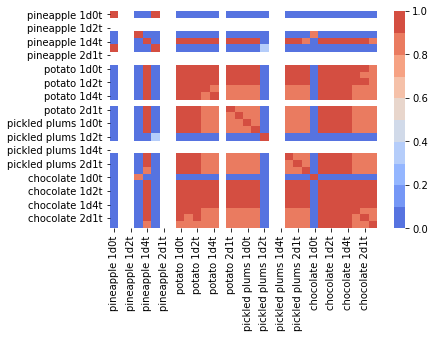

In [50]:
re_index = []
re_index.extend(pine1)
re_index.extend(pine2)
re_index.extend(potato1)
re_index.extend(potato2)
re_index.extend(ume1)
re_index.extend(ume2)
re_index.extend(chocolate1)
re_index.extend(chocolate2)
df = df.reindex(re_index, axis='columns')
df = df.reindex(re_index, axis='index')

sns.heatmap(df, cmap= sns.color_palette('coolwarm', 10), vmin = 0, vmax = 1)
plt.plot()

[]

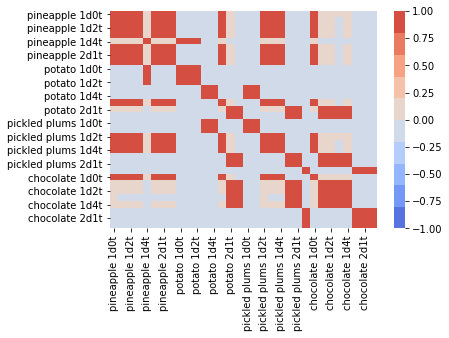

In [51]:
hist = np.load("emg_VAE_npy/emg_vq_vae-{}-{}dim.npy".format(num_embeddings, embedding_dim))

all_coef = []
for i in range(len(index)):
    coef = []
    for j in range(len(index)):
        coef.append(np.corrcoef(hist[i], hist[j])[0,1])
    all_coef.append(coef)
all_coef = np.array(all_coef)
df = pd.DataFrame(data=all_coef, index=index, columns=columns, dtype='float')
df = df.reindex(re_index, axis='columns')
df = df.reindex(re_index, axis='index')

sns.heatmap(df, cmap= sns.color_palette('coolwarm', 10), vmin = -1, vmax = 1)
plt.plot()

In [25]:
hist.shape

(30, 256)

In [24]:
all_cos_sequence.shape

(30, 1498)

In [33]:
minas = np.count_nonzero(all_cos_sequence < 0, axis=1)
for i in range(6):
    print(minas[i*5:(i+1)*5])
print(minas)
np.where(minas > 850)

[797 775 836 827 867]
[918 994 708 430 447]
[ 482  846  913 1012 1000]
[848 806 898 822 761]
[762 786 592 430 487]
[499 854 879 948 958]
[ 797  775  836  827  867  918  994  708  430  447  482  846  913 1012
 1000  848  806  898  822  761  762  786  592  430  487  499  854  879
  948  958]


(array([ 4,  5,  6, 12, 13, 14, 17, 26, 27, 28, 29]),)

# Decoderへの入力のPCA解析

In [ ]:
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
pca = PCA()

out = out.reshape(30, -1)

# 中間層の標準化
ss = preprocessing.StandardScaler()
print(out.shape)
encode = ss.fit_transform(out)

label = [1, 2, 3, 4, 5, 6]
labels = []
for i in label:
    labels.extend([i, i, i, i, i])

pca.fit(encode)
feature = pca.transform(encode)

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1)

label = ['cherry', 'meatball', 'watermelon', 'tomato', 'salted plum', 'wiener']
# ax.scatter(feature[:5,0],feature[:5,1], c='red', marker='.', label='cherry')
# ax.scatter(feature[5:10,0],feature[5:10,1], c='blue',marker='o', label='meatball')
# ax.scatter(feature[10:15,0],feature[10:15,1], c='green',marker='^', label='watermelon')
# ax.scatter(feature[15:20,0],feature[15:20,1], c='yellow',marker='s', label='tomato')
# ax.scatter(feature[20:25,0],feature[20:25,1], c='m',marker='x', label='salted plum')
# ax.scatter(feature[25:,0],feature[25:,1], c='k',marker='+', label='wiener')
ax.scatter(feature[:5,0],feature[:5,1], c='red', marker='.', label='cherry')
ax.scatter(feature[5:10,0],feature[5:10,1], c='blue',marker='o', label='meatball')
ax.scatter(feature[10:15,0],feature[10:15,1], c='red',marker='^', label='watermelon')
ax.scatter(feature[15:20,0],feature[15:20,1], c='blue',marker='s', label='tomato')
ax.scatter(feature[20:25,0],feature[20:25,1], c='blue',marker='x', label='salted plum')
ax.scatter(feature[25:,0],feature[25:,1], c='blue',marker='+', label='wiener')

#ax.set_title('fourth scatter plot')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2', rotation=0)

ax.grid(True)

#ax.legend(loc='upper right')
#lgd=ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
# name = "pdf/emg_vq_vae-{}-{}.pdf".format(num_embeddings, embedding_dim)
# fig.savefig(name, bbox_inch='tight')
fig.show()

In [ ]:
import matplotlib.ticker as ticker
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.plot([0] + list( np.cumsum(pca.explained_variance_ratio_)), "-o")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative contribution rate")
plt.grid()
plt.show()